In [1]:
%run util.py

miss rate of LDA = 0.11818181818181818
miss rate of QDA = 0.10909090909090909


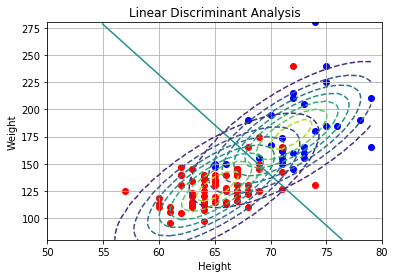

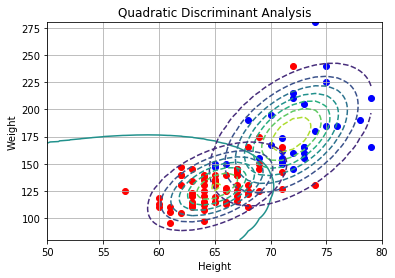

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import util

def discrimAnalysis(x, y):
    """
    Estimate the parameters in LDA/QDA and visualize the LDA/QDA models

    Inputs
    ------
    x: a N-by-2 2D array contains the height/weight data of the N samples

    y: a N-by-1 1D array contains the labels of the N samples

    Outputs
    -----
    A tuple of five elments: mu_male,mu_female,cov,cov_male,cov_female
    in which mu_male, mu_female are mean vectors (as 1D arrays)
             cov, cov_male, cov_female are covariance matrices (as 2D arrays)
    Besides producing the five outputs, you need also to plot 1 figure for LDA
    and 1 figure for QDA in this function
    """

    N = len(x)

    male_height = []
    male_weight = []
    female_height = []
    female_weight = []

    for index in range(x.shape[0]):
        if y[index] == 1:
            male_height.append(x[index][0])
            male_weight.append(x[index][1])
        else:
            female_height.append(x[index][0])
            female_weight.append(x[index][1])


    # compute mu_male, mu_female
    mu_male_height = sum(male_height) / len(male_height)
    mu_male_weight = sum(male_weight) / len(male_weight)
    mu_female_height = sum(female_height) / len(female_height)
    mu_female_weight = sum(female_weight) / len(female_weight)

    mu_male = np.array([mu_male_height, mu_male_weight])
    mu_female = np.array([mu_female_height, mu_female_weight])


    # compute cov
    mu_overall = np.sum(x, axis = 0) / len(x)
    cov = np.zeros([2, 2])
    cov[0][0] = (x[:,0] - mu_overall[0]).T @ (x[:,0] - mu_overall[0]) / N
    cov[0][1] = (x[:,0] - mu_overall[0]).T @ (x[:,1] - mu_overall[1]) / N
    cov[1][0] = (x[:,1] - mu_overall[1]).T @ (x[:,0] - mu_overall[0]) / N
    cov[1][1] = (x[:,1] - mu_overall[1]).T @ (x[:,1] - mu_overall[1]) / N

    # compute cov_male
    cov_male = np.zeros([2, 2])
    cov_male[0][0] = (male_height - mu_male_height).T @ (male_height - mu_male_height) / len(male_height)
    cov_male[0][1] = (male_height - mu_male_height).T @ (male_weight - mu_male_weight) / len(male_height)
    cov_male[1][0] = (male_weight - mu_male_weight).T @ (male_height - mu_male_height) / len(male_height)
    cov_male[1][1] = (male_weight - mu_male_weight).T @ (male_weight - mu_male_weight) / len(male_height)

    # compute cov_female
    cov_female = np.zeros([2, 2])
    cov_female[0][0] = (female_height - mu_female_height).T @ (female_height - mu_female_height) / len(female_height)
    cov_female[0][1] = (female_height - mu_female_height).T @ (female_weight - mu_female_weight) / len(female_height)
    cov_female[1][0] = (female_weight - mu_female_weight).T @ (female_height - mu_female_height) / len(female_height)
    cov_female[1][1] = (female_weight - mu_female_weight).T @ (female_weight - mu_female_weight) / len(female_height)
    
    plt.figure()
    plt.grid()
    plt.title("Linear Discriminant Analysis")
    plt.scatter(male_height, male_weight, color = 'blue')
    plt.scatter(female_height, female_weight, color = 'red')
    plt.xlabel('Height')
    plt.ylabel('Weight')
    plt.xlim(50, 80)
    plt.ylim(80, 280)
    h = np.arange(50, 80)
    w = np.arange(80, 280)
    H, W = np.meshgrid(h, w)
    male = np.zeros([200, 30])
    female = np.zeros([200, 30])
    for row in range(50,80):
        rc = []
        for col in range(80,280):
            rc.append([row,col])
        male[:,row - 50] = density_Gaussian(mu_male, cov, np.array(rc))
        female[:,row -80] = density_Gaussian(mu_female, cov, np.array(rc))
    beta1 = np.linalg.inv(cov) @ mu_male
    gamma1 = -(mu_male.T @ np.linalg.inv(cov) @ mu_male) / 2
    beta2 = np.linalg.inv(cov) @ mu_female
    gamma2 = -(mu_female.T @ np.linalg.inv(cov) @ mu_female) / 2
    y_lda = gamma1 + beta1[0] * H + beta1[1] * W - gamma2 - beta2[0] * H - beta2[1] * W
    plt.contour(H, W, y_lda, 0)
    plt.contour(H, W, male, linestyles='dashed')
    plt.contour(H, W, female, linestyles='dashed')
    plt.savefig("LDA.pdf")

    plt.figure()
    plt.grid()
    plt.title("Quadratic Discriminant Analysis")
    plt.scatter(male_height, male_weight, color = 'blue')
    plt.scatter(female_height, female_weight, color = 'red')
    plt.xlabel('Height')
    plt.ylabel('Weight')
    plt.xlim(50, 80)
    plt.ylim(80, 280)
    h = np.arange(50, 80)
    w = np.arange(80, 280)
    H, W = np.meshgrid(h, w)
    male = np.zeros([200, 30])
    female = np.zeros([200, 30])
    for row in range(50,80):
        rc = []
        for col in range(80,280):
            rc.append([row,col])
        male[:,row - 50] = density_Gaussian(mu_male, cov_male, np.array(rc))
        female[:,row -80] = density_Gaussian(mu_female, cov_female, np.array(rc))

    y_qda = male - female
    plt.contour(H, W, y_qda, 0)
    plt.contour(H, W, male, linestyles='dashed')
    plt.contour(H, W, female, linestyles='dashed')
    plt.savefig("QDA.pdf")


    return (mu_male,mu_female,cov,cov_male,cov_female)


def misRate(mu_male,mu_female,cov,cov_male,cov_female,x,y):
    """
    Use LDA/QDA on the testing set and compute the misclassification rate

    Inputs
    ------
    mu_male,mu_female,cov,cov_male,mu_female: parameters from discrimAnalysis

    x: a N-by-2 2D array contains the height/weight data of the N samples

    y: a N-by-1 1D array contains the labels of the N samples

    Outputs
    -----
    A tuple of two elements: (mis rate in LDA, mis rate in QDA)
    """

    # Linear Discriminant Analysis
    beta1 = np.linalg.inv(cov) @ mu_male
    gamma1 = -(mu_male.T @ np.linalg.inv(cov) @ mu_male) / 2
    beta2 = np.linalg.inv(cov) @ mu_female
    gamma2 = -(mu_female.T @ np.linalg.inv(cov) @ mu_female) / 2

    y_lda = gamma1 + beta1 @ x.T - gamma2 - beta2 @ x.T

    for index in range(y_lda.shape[0]):
        if y_lda[index] > 0:
            y_lda[index] = 1
        else:
            y_lda[index] = 2

    comparison = y_lda - y
    miss_class = 0
    for difference in comparison:
        if difference != 0:
            miss_class += 1

    mis_lda = miss_class / len(y)


    # Quadratic Discriminant Analysis
    y_hat1 = np.zeros(len(y))
    y_hat2 = np.zeros(len(y))

    for i in range(x.shape[0]):
        y_hat1[i] = - np.dot((x[i].T - mu_male) @ np.linalg.inv(cov_male),(x[i] - mu_male)) - np.log(np.linalg.det(cov_male))
        y_hat2[i] = - np.dot((x[i].T - mu_female) @ np.linalg.inv(cov_female),(x[i] - mu_female)) - np.log(np.linalg.det(cov_female))

    y_qda = y_hat1 - y_hat2

    for index in range(y_qda.shape[0]):
        if y_qda[index] > 0:
            y_qda[index] = 1
        else:
            y_qda[index] = 2

    comparison = y_qda - y
    miss_class = 0
    for difference in comparison:
        if difference != 0:
            miss_class += 1

    mis_qda = miss_class / len(y)


    return (mis_lda, mis_qda)


if __name__ == '__main__':

    # load training data and testing data
    x_train, y_train = util.get_data_in_file('trainHeightWeight.txt')
    x_test, y_test = util.get_data_in_file('testHeightWeight.txt')

    # parameter estimation and visualization in LDA/QDA
    mu_male,mu_female,cov,cov_male,cov_female = discrimAnalysis(x_train,y_train)

    # misclassification rate computation
    mis_LDA,mis_QDA = misRate(mu_male,mu_female,cov,cov_male,cov_female,x_test,y_test)

    print('miss rate of LDA = {}'.format(mis_LDA))
    print('miss rate of QDA = {}'.format(mis_QDA))
